### Natural Language Processing Project: "First Take"

MSDS NLP

Kishan Panchal

<img src="../presenters.jpg">

This project aims to see if we can distinguish between the tweets of Stephen A. Smith (left) and Skip  Bayless (right) and model the topics that they tweet about as well. They are two prominent sports debaters who used to work together on a show called "First Take" on ESPN before leading their own sports debate shows. Since they work in the media, both are known for their strong opinions and exaggerations, and now that they do no directly debate with each other, some of their opinions are very similar, and they both comment on recent sports news. Thus, it is interesting to take their tweets and see if we can distinguish between the two.

### Data Acquisition

To acquire the data, I used the the Twitter teepy API to request the most recent 3,200 tweets for both Stephen A. Smith (@stephenasmith) and Skip Bayless (@RealSkipBayless). The earliest date for a tweet was November 3, 2016 for Stephen A. and September 17, 2017 for Skip and the most recent date is May 31, 2018 for both people. The script is included within another file. After obtaining the data for both people, I combined it together and labeled tweets by Stephen A. and Skip so that we can distnguish between them.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
import pandas as pd   
import numpy as np
import re
import pickle

from nltk.corpus import stopwords 
from collections import Counter
import pyLDAvis.gensim
from gensim import corpora, models, similarities

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score
from display_cm import *

from sklearn.model_selection import GridSearchCV

pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [3]:
smith = pd.read_csv('../Data/stephenasmith_tweets.csv')
smith['label'] = 0

skip = pd.read_csv('../Data/RealSkipBayless_tweets.csv')
skip['label'] = 1

In [4]:
smith.head(4)

,id,created_at,text,label
0,1002000207343534080,2018-05-31 01:34:00,After Dark Podcast: Reasons why Colangelo dese...,0
1,1001920206288060417,2018-05-30 20:16:06,RT @FirstTake: The stage is finally set. Join ...,0
2,1001868088353181697,2018-05-30 16:49:00,My Lord!!! We're talking burner accounts. #ESP...,0
3,1001665250985463809,2018-05-30 03:23:00,Stephen A. Smith After Dark Podcast: The @Warr...,0


In [5]:
skip.head(4)

,id,created_at,text,label
0,1001998406540292097,2018-05-31 01:26:51,I've got a funny feeling about this Finals.,1
1,1001908778441236482,2018-05-30 19:30:42,Today's Undisputed podcast: https://t.co/OA90o...,1
2,1001839619162296322,2018-05-30 14:55:53,Are the Lakers getting serious about drafting ...,1
3,1001836769703223296,2018-05-30 14:44:33,"The Warriors are vulnerable. More @Undisputed,...",1


In [6]:
smith_df = smith[['text', 'label']]
skip_df = skip[['text', 'label']]

train = pd.concat( [smith_df, skip_df] ).reset_index()

In [7]:
train['text'][0]

'After Dark Podcast: Reasons why Colangelo deserves the benefit of the doubt. @IsiahThomas joins with a fantastic MJ v. LeBron argument. https://t.co/1sy8aKjl30'

### Data Processing

Now we need to clean the tweet data. We can do this by removing non-letter characters, getting rid of any links mentioned in the tweets, converting words to lower case, removing stop words, and removing words from other_stops, which are words that appear in tweets that make it easier to identify the tweet owner. Stemming ends up removing some of the meaning of words in this case and thus was not used.

These include twitter handles of cohosts and mentions of the names of the TV shows and companies that Stephen A. and Skip work for.

In [8]:
other_stops = ['stephen', 'a.', 'smith', 'skip bayless', '@undisputed.',\
               '@undisputed', '9:30','rt','&amp', '&amp;', '@undisputed:', \
               '@firsttake', '@firsttake:', 'et.', 'fs1', 'shannon sharpe',\
               'stephen a.', 'a. smith', 'a', ',', '@stephenasmith', '@ShannonSharpe',\
               '@RealSkipBayless', 'undisputed', '-', 'after', 'dark', 'first', 'take',
               '@maxkellerman', 'espn', 'podcast', 'podcast:', '.@stephenasmith',\
               '@undisputed,', '...', 'vs', '--', 'firsttake', 'stephenasmith',
               'amp', 'fs', 'et', 'maxkellerman', 'ShannonSharpe', 'facebook',
               'max', 'kellerman', 'shannon', 'sharpe']

In [9]:
def process_tweet(tweet):

    no_links = re.sub(r'(www|http:|https:)+[^\s]+[\w]', ' ', str(tweet))
    
    letters_only = re.sub(r'[^a-zA-Z]', ' ', str(no_links)) 
        
    words = letters_only.lower().split()
    
    words = [w for w in words if w not in set(stopwords.words("english"))] 
    
    words = [w for w in words if w not in set(other_stops)]
    
    words = [w for w in words if len(w) > 1]
    
    return " ".join(words)

In [10]:
print('Original Tweet: ' + '%s' %(train['text'][2]))

print('\nCleaned tweet: ' + '%s' %(process_tweet(train['text'][2])))

Original Tweet: My Lord!!! We're talking burner accounts. #ESPNradio https://t.co/og47lCKozx https://t.co/CXRHy9HrLU

Cleaned tweet: lord talking burner accounts espnradio


In [11]:
train['text'] = train['text'].apply(process_tweet)

In [12]:
train.sample(5)

,index,text,label
6179,2954,pretty sure loss cost baker mayfield heisman n...,1
770,770,give break,0
373,373,oh tomorrow gonna special much ammo talk nba p...,0
175,175,brad stevens man,0
5337,2112,tom brady bad game hear see old losing watch y...,1


In [13]:
pickle.dump( train, open("../Data/train.csv", "wb") )

In [14]:
train = pickle.load( open("../Data/train.csv", "rb") )

### Exploratory Data Analysis

#### Most Frequent Words Used

What are the top 25 most common words used by Stephen A. Smith?

In [15]:
smith_tokens = " ".join(train[train['label']==0]['text']).split(" ")
smith_dict = Counter(smith_tokens)

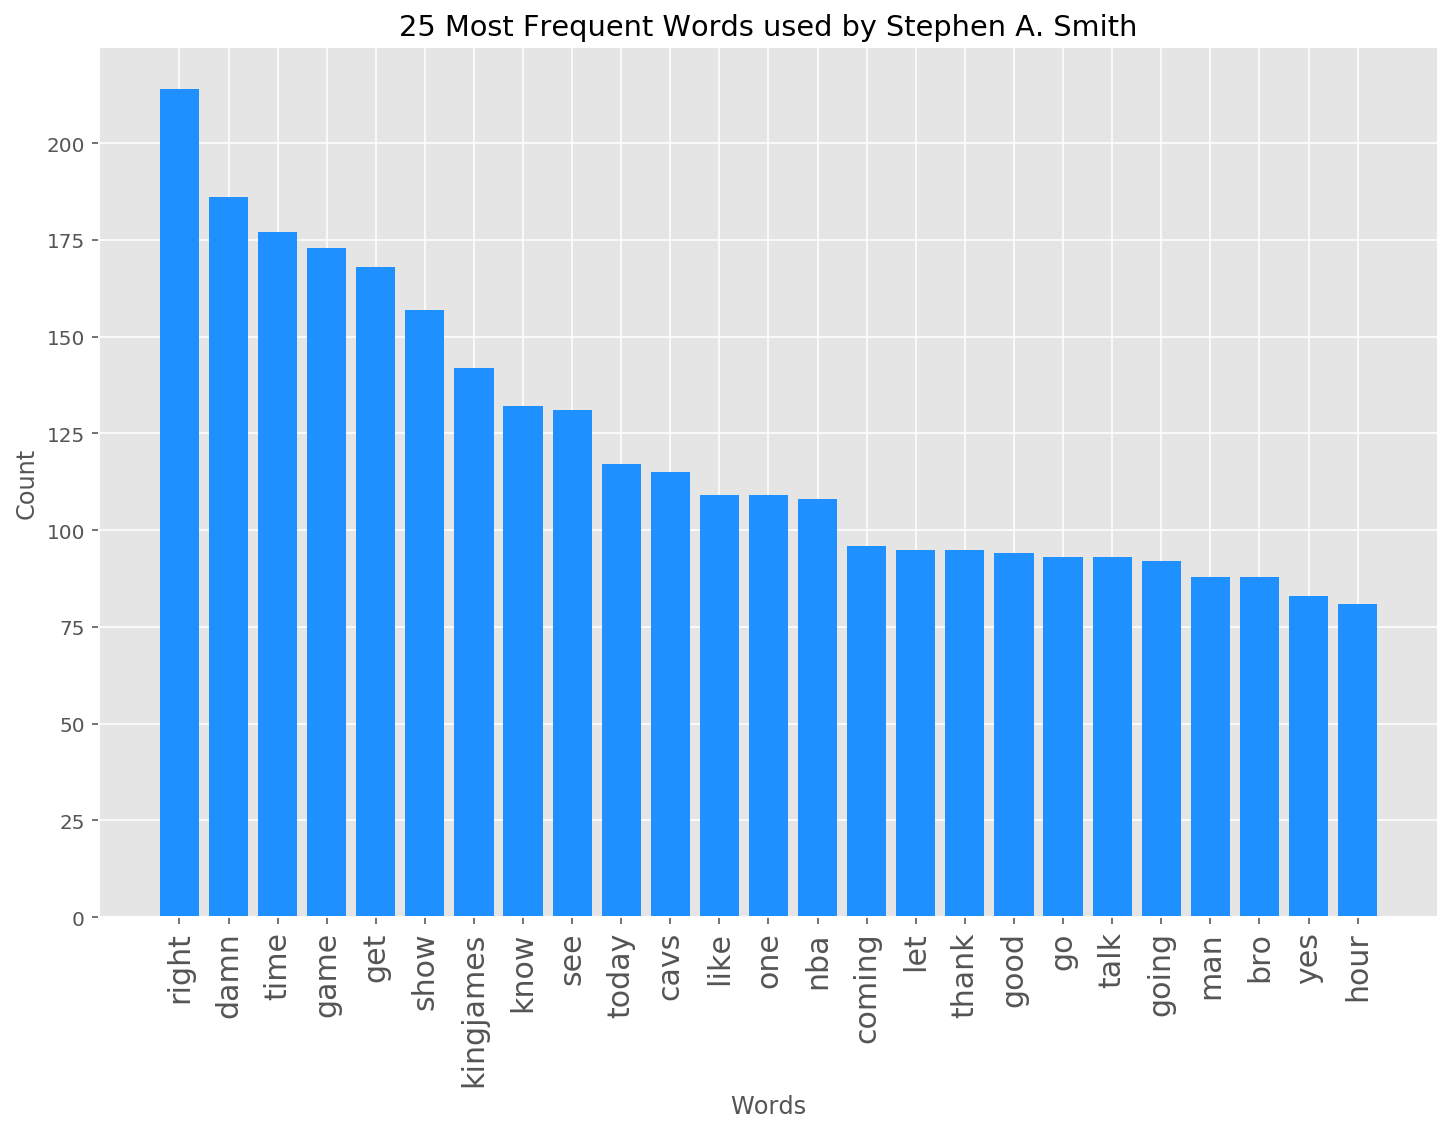

In [16]:
labels, values = zip(*smith_dict.most_common(25))

plt.figure(figsize=(12,8))
plt.bar(labels, values, color = 'dodgerblue')
plt.xticks(labels, rotation = 90, size=15)
plt.xlabel('Words', size=12)
plt.ylabel('Count', size=12)
plt.title('25 Most Frequent Words used by Stephen A. Smith')
plt.show()

What are the 25 most common words used by Skip Bayless?

In [17]:
skip_tokens = " ".join(train[train['label']==1]['text']).split(" ")
skip_dict = Counter(skip_tokens)

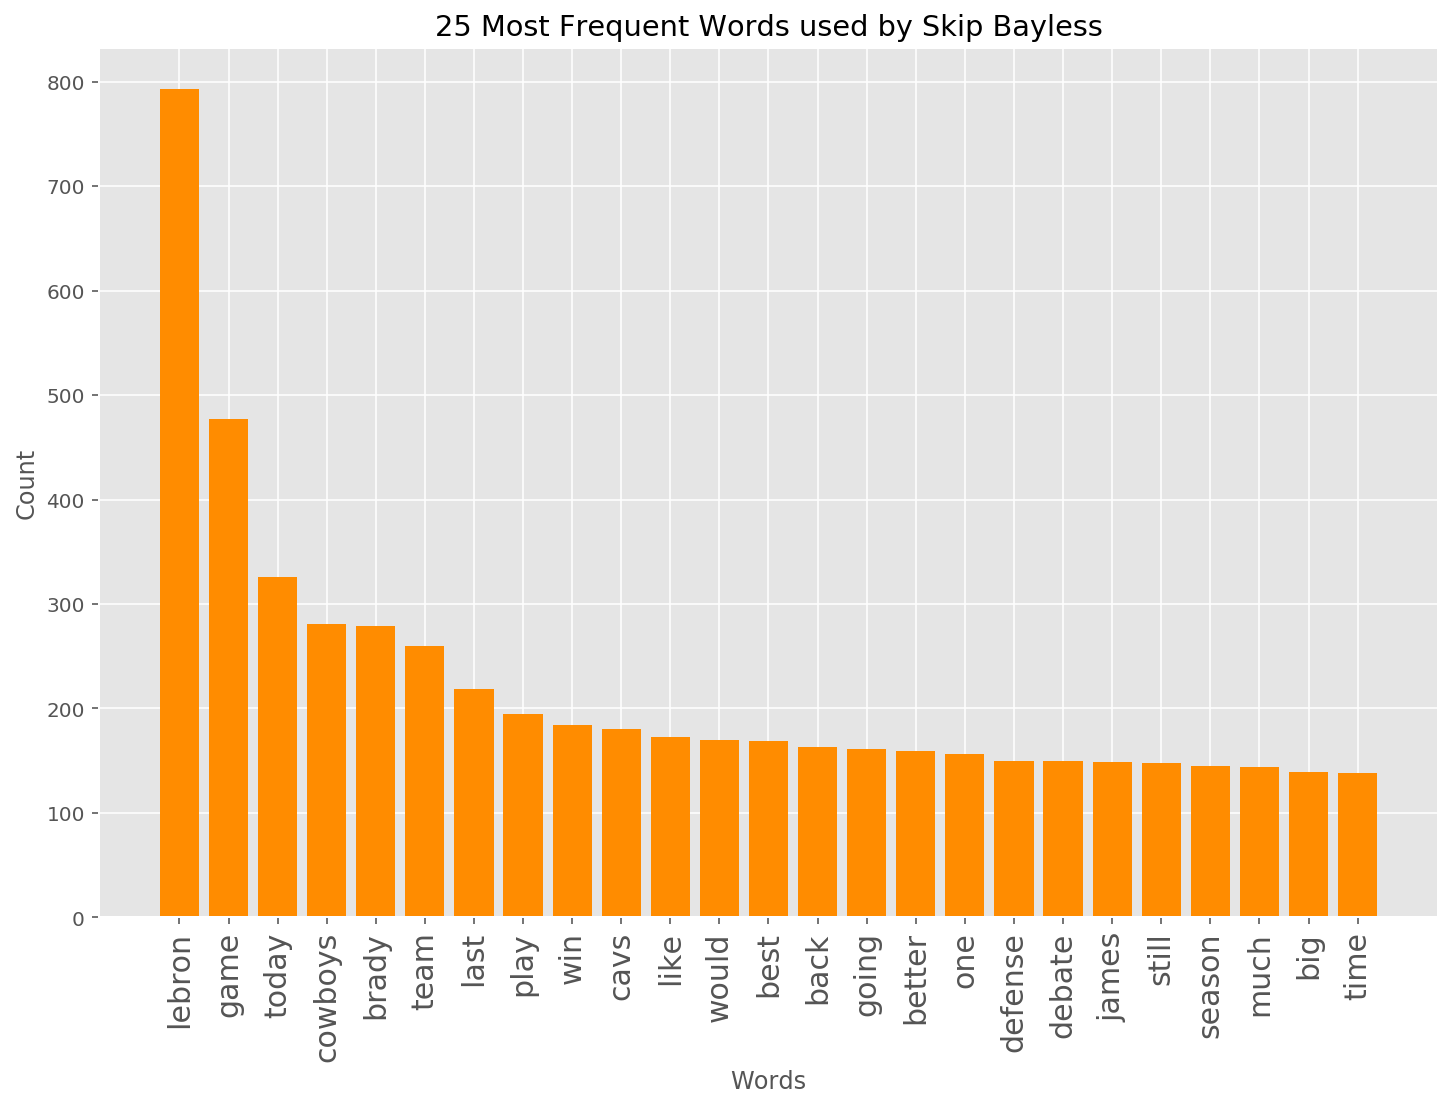

In [18]:
labels, values = zip(*skip_dict.most_common(25))

plt.figure(figsize=(12,8))
plt.bar(labels, values, color = 'darkorange')
plt.xticks(labels, rotation = 90, size=15)
plt.xlabel('Words', size=12)
plt.ylabel('Count', size=12)
plt.title('25 Most Frequent Words used by Skip Bayless')
plt.show()

From the two graphs above, it looks like Skip refers to LeBron James (lebron), the Dallas Cowboys (cowboys), and the Cleveland Cavaliers (cavs) the most in his tweets whereas Stephen A. uses the word 'damn' quite frequently and also mentions LeBron James (kingjames) and the Cleveland Cavaliers (cavs) as well. These plots also depend on the fact that LeBron James routinely breaks NBA records, so it makes sense that he would be mentioned quite often by individuals working in sports debate.

### Topic Modeling

Topic modeling will help us get a sense of the topics that these sports personalities have talked about from their tweets. Let's check out the five main topics their tweets were about.

Each topic is represented by a circle, and the area of each circle represents the prevalence of a topic, and the numbers in ascending order represent the largest areas. The distance between circles represents topic similarity. Clicking on a circle will give you the most revelant words in a topic. The red bar is the term frequency in this topic, and the blue bar is the overall term frequency. Sliding the lambda slider to 0 results in terms that are mostly only relevant to the topic itself.

In [19]:
all_texts = [ text.split(' ') for text in train['text'] ]
dictionary = corpora.Dictionary(all_texts)

corpus = [dictionary.doc2bow(text) for text in all_texts]
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary)

viz = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
viz

/Users/mbk/anaconda/envs/nlp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.070555 -0.073244       1        1  27.069378
2      0.024895 -0.048867       2        1  21.780216
0     -0.087737  0.127827       3        1  17.720327
4     -0.116924 -0.080587       4        1  16.937489
1      0.109212  0.074871       5        1  16.492582, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
419   Default  509.000000     today  509.000000  30.0000  30.0000
1824  Default  240.000000    debate  240.000000  29.0000  29.0000
1381  Default  626.000000   cowboys  626.000000  28.0000  28.0000
1276  Default  198.000000       dez  198.000000  27.0000  27.0000
3138  Default  304.000000       dak  304.000000  26.0000  26.0000
3412  Default  102.000000      rams  102.000000  25.0000  25.0000
582   Default  147.000000      lost  147.000000  24.0000  24.0000
1163  Default   86.000000      melo   86.000000  23.0000  23.0000
247   Default   84.000000      russ   84.000000  22.0000  22.0000
3025  Default  126.000000       cam  126.000000  21.0000  21.0000
2060  Default   91.000000      eric   91.000000  20.0000  20.0000
138   Default  203.000000        go  203.000000  19.0000  19.0000
595   Default   95.000000    played   95.000000  18.0000  18.0000
100   Default  578.000000      game  578.000000  17.0000  17.0000
393   Default  306.000000      play  306.000000  16.0000  16.0000
6732  Default  102.000000     odell  102.000000  15.0000  15.0000
590   Default  119.000000     kyrie  119.000000  14.0000  14.0000
2109  Default  158.000000     aaron  158.000000  13.0000  13.0000
3315  Default   62.000000    throws   62.000000  12.0000  12.0000
1999  Default  160.000000     lonzo  160.000000  11.0000  11.0000
3139  Default   68.000000  prescott   68.000000  10.0000  10.0000
2113  Default  133.000000   rodgers  133.000000   9.0000   9.0000
1484  Default   61.000000    clutch   61.000000   8.0000   8.0000
68    Default   64.000000  greatest   64.000000   7.0000   7.0000
700   Default   90.000000     jerry   90.000000   6.0000   6.0000
154   Default   52.000000      drop   52.000000   5.0000   5.0000
2795  Default   66.000000       nfc   66.000000   4.0000   4.0000
8     Default  687.000000    lebron  687.000000   3.0000   3.0000
3979  Default   58.000000     wentz   58.000000   2.0000   2.0000
1970  Default   87.000000     kawhi   87.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
353    Topic5   26.375235      bout   32.649490   1.5889  -6.0041
1381   Topic5  244.934891   cowboys  626.737671   0.8627  -3.7756
2840   Topic5   34.765839      hand   52.707664   1.3861  -5.7279
9      Topic5   34.105610        mj   53.206818   1.3575  -5.7471
6416   Topic5   31.604105     brice   47.938622   1.3856  -5.8233
393    Topic5  104.258057      play  306.854065   0.7228  -4.6297
1636   Topic5   28.990900    harden   45.479843   1.3520  -5.9096
100    Topic5  118.498077      game  578.932373   0.2160  -4.5017
3201   Topic5   35.107067     yards   70.131195   1.1103  -5.7182
8      Topic5  102.302116    lebron  687.563965  -0.1030  -4.6486
374    Topic5   57.067936       big  212.056335   0.4896  -5.2323
559    Topic5   43.598118      made  124.833237   0.7503  -5.5016
545    Topic5   62.098911      team  307.475830   0.2026  -5.1478
31     Topic5   59.313339       win  280.949036   0.2469  -5.1937
69     Topic5   37.036400       man   94.684814   0.8636  -5.6647
157    Topic5   39.416393   tonight  118.576584   0.7009  -5.6024
225    Topic5   48.459248       one  237.452316   0.2130  -5.3958
104    Topic5   29.305338        nd   54.200737   1.1873  -5.8988
263    Topic5   47.836117      last  282.112915   0.0277  -5.4088
93     Topic5   32.379318    second   75.826782   0.9513  -5.7991
139    Topic5   42.953358     going  211.439957   0.2084  -5.5165
277    Topic5  

From the above visualization, we notice that Topic 1 is primarily basketball-related, as it contains many references to LeBron James, Lonzo Ball, Magic Johnson, LaVar Ball, Carmelo Anthony, and the Oklahoma City Thunder.

Topic 2 seems like more of a mix of basketball and football, and Topic 3 seems like a primarily football topic with references to Tom Brady, Dez Bryant, the New England Patriots, DeShaun Jackson, the Dallas Cowboys, Ezekeiel Elliot, Bill Belichick, Baker Mayfield, and Rob Gronkowski. Topic 4 is also mainly football-focused, and Topic 5 is football and baseball-related.

Thus, the two main topics that Stephen A. Smith and Skip Bayless tweeted about were basketball and football.

### Modeling 

We will model this data using three machine learning algorithms: Random Forest, Logistic Regression, and Multinomial Naive Bayes.

In training these models, we will utilize Grid Search Cross Validation on each of these models and use the cross-validated F1-Score as our evaluation metric to decide which one of these models is optimal.

Because our text data needs to be converted into numerical format before we model it, we will use the TFIDF (term frequency inverse document frequency) vectorizer, which creates tokens based on word frequencies but reduces the weight of a word by the frequency of that word in the corpus. This means that we will get not only a count of the word but also how important it is in a document/tweet.

In [20]:
X=np.array(train['text'])
y=np.array(train['label'])

In [21]:
vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 20000) 

In [22]:
train_data_features = vectorizer.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_data_features, y, test_size=0.15, random_state=42)

In [24]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5466, 8719) (5466,) (965, 8719) (965,)


In [51]:
def display_f1(true_labels, predicted_labels, positive_class=1):
    print( 'F1 Score:', np.round(
                            f1_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'), 3))

### Random Forest

Random forest classifiers are models that utilize the ensemble learning technique by creating several decision trees and taking the mode class that is predicted by these trees.

The hyperparameters of the Random Forest model we are going to tune include: 
 - n_estimators - this is the numbers of trees that will be used in the forest
 - max_features - the maximum number of features to consider when looking to split a node

In [33]:
rfc = RandomForestClassifier(random_state = 42)

param_grid = {'n_estimators' : [100, 200, 300],
              'max_features' : ['log2', 'sqrt']}

rf_gd = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='f1', n_jobs = -1)

rf_gd.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300], 'max_features': ['log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

We can look at the 5 fold cross validation best score.

In [34]:
print(rf_gd.best_params_, rf_gd.best_score_)

{'max_features': 'log2', 'n_estimators': 300} 0.8834081983178638


In [43]:
rfc_best = RandomForestClassifier(n_estimators = 300, max_features = 'log2'
                                  , random_state = 42, n_jobs = -1)
rfc_best.fit(X_train, y_train)
test_preds = rfc_best.predict(X_test)

In [52]:
display_f1(y_test, test_preds)

F1 Score: 0.883


### Logistic Regression

Logistic regression is a binary classification technique that produces a logistic curve that is limited to values between 0 and 1. This curve is created using the natural logarithm of the odds ratio $p/(1-p)$ of the response variable, and the general equation for a logistic regression model would look like: $ln(p/1-p) = b_{0} + b_{1}x$

The hyperparameters of the Logistic Regression model we are going to tune include: 
 - penalty - whether to use L1 or L2 regularization 
 - C - this parameter helps to reduce the magnitude of the parameters. It is equivalent to 1/$\lambda$, and small values of C increase the regularization strength that could lead to simple models that underfit the data. Large values of C mean that you lower the regularization, which increases model complexity, which can cause the model to overfit the data.

In [35]:
lr = LogisticRegression(random_state = 42)

param_grid = {'penalty': ['l1', 'l2'], 
              'C':np.logspace(0, 2, 10)}

lr_gd = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='f1', n_jobs = -1)

lr_gd.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.     ,   1.6681 ,   2.78256,   4.64159,   7.74264,  12.9155 ,
        21.54435,  35.93814,  59.94843, 100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

We can observe the results of this 5 fold cross validation.

In [36]:
print(lr_gd.best_params_)
print(lr_gd.best_score_)

{'C': 4.641588833612778, 'penalty': 'l2'}
0.8907446945436435


In [53]:
lr_best = LogisticRegression(C = 4.641588, penalty = 'l2'
                                  , random_state = 42, n_jobs = -1)
lr_best.fit(X_train, y_train)
test_preds = lr_best.predict(X_test)

display_f1(y_test, test_preds)

F1 Score: 0.892


### Multinomial Naive Bayes

The multinomial naive bayes model is a variation of the naive bayes model where features represent the event that a single word occurs within a document.

The hyperparameters of the Multinomial Naive Bayes model we are going to tune include: 
 - alpha - this is the laplace smooting parameter where 0 means no smoothing
 - fit_prior - whether to learn class prior probabilities or not

In [38]:
mnb = MultinomialNB()

param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
              'fit_prior':[True, False]}

mnb_gd = GridSearchCV(estimator=mnb, param_grid=param_grid, cv=5, scoring='f1', n_jobs = -1)

mnb_gd.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [39]:
print(mnb_gd.best_params_, mnb_gd.best_score_)

{'alpha': 0.2, 'fit_prior': False} 0.9002167878047762


In [40]:
mnb_best = MultinomialNB(alpha = 0.2, fit_prior = False)
mnb_best = mnb_best.fit( X_train, y_train )

In [54]:
test_preds_mnb = mnb_best.predict(X_test)

display_f1(y_test, test_preds_mnb)

F1 Score: 0.897


### Evaluation

We see that the best model based on cross-validation based f1 score is Multinomial Naive Bayes with a score of 0.900, and it also has the best F1 score on the hold out test set of 0.897.

### Experimentation with Glove word vectors

We can also try to use word vectors from from the https://nlp.stanford.edu/projects/glove/ instead of the Tfidfvectorizer for tokenizing our tweets and see if that helps our predictive accuracy.

In [55]:
def load_glove(filename):
    dict = {}
    allLines = open(filename, 'r')
    for line in allLines:
        elements = line.replace('\r', '').replace('\n', '').split(' ')
        word = elements[0]
        items2 = [ float(v) for v in elements[1:] ]
        the_nums = np.asarray(items2)  
        dict[str(word)] = the_nums          
    return dict   

In [57]:
def doc2vec(text, gloves):
    dimension = list(gloves.values())[0].shape
    word_vect_sum = np.zeros(dimension, dtype='float')
    common = [w for w in text if w in gloves]
    for w in common:
        word_vect_sum += gloves[w]
    return word_vect_sum / len(common) if len(common) != 0 else word_vect_sum

In [75]:
glove = load_glove('/Users/mbk/desktop/glove.6B/glove.6B.100d.txt')

In [59]:
tweet_embedding = [doc2vec(tweet, glove) for tweet in train['text']]

Now let's create train and test sets like we did above with the same test size of 0.15 except using the tweet embedding instead of the Tfidfvectorizer tokens above. 

In [60]:
X_train, X_test, y_train, y_test = train_test_split(tweet_embedding, train['label'], test_size = 0.15, random_state=42)

### Random Forest

In [61]:
rfc = RandomForestClassifier(random_state = 42)

param_grid = {'n_estimators' : [100, 200, 300],
              'max_features' : ['log2', 'sqrt']}

rf_gd = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='f1', n_jobs = -1)

rf_gd.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300], 'max_features': ['log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [62]:
print(rf_gd.best_params_, rf_gd.best_score_)

{'max_features': 'sqrt', 'n_estimators': 200} 0.6647010144487951


The cross-validated F1 score is about 0.665.

### Logistic Regression

In [65]:
lr = LogisticRegression(random_state = 42)

param_grid = {'penalty': ['l1', 'l2'], 
              'C':np.logspace(0, 2, 10)}

lr_gd = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='f1', n_jobs = -1)

lr_gd.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.     ,   1.6681 ,   2.78256,   4.64159,   7.74264,  12.9155 ,
        21.54435,  35.93814,  59.94843, 100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [66]:
print(lr_gd.best_params_)
print(lr_gd.best_score_)

{'C': 1.6681005372000588, 'penalty': 'l1'}
0.6414315482120417


The cross-validated F1 score is about 0.641.

### Multinomial Naive Bayes

Glove vectors sometimes contain negative values, whereas Naive Bayes is only compatible with positive values (it assumes document frequencies). Using sklearn.preprocessing.MinMaxScaler() to scale the training features to [0, 1] would be altering the data too much if many of our features are within a very small range, so we are unable to check whether glove vectors would help much in this case.

### Final Verdict

From the results above, we saw that utilizing Glove vectors did not help in this case. This might be because tweet data is quite sparse, especially after cleaning it, but in this case, using tokens from the Tfidfvectorizer did better.

The cross-validated F1 scores for the models that used Glove vectors were lower than the models without them, so our best model is still MultinomialNB(alpha = 0.2, fit_prior = False).

Lastly, let's look at a confusion matrix of the results.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


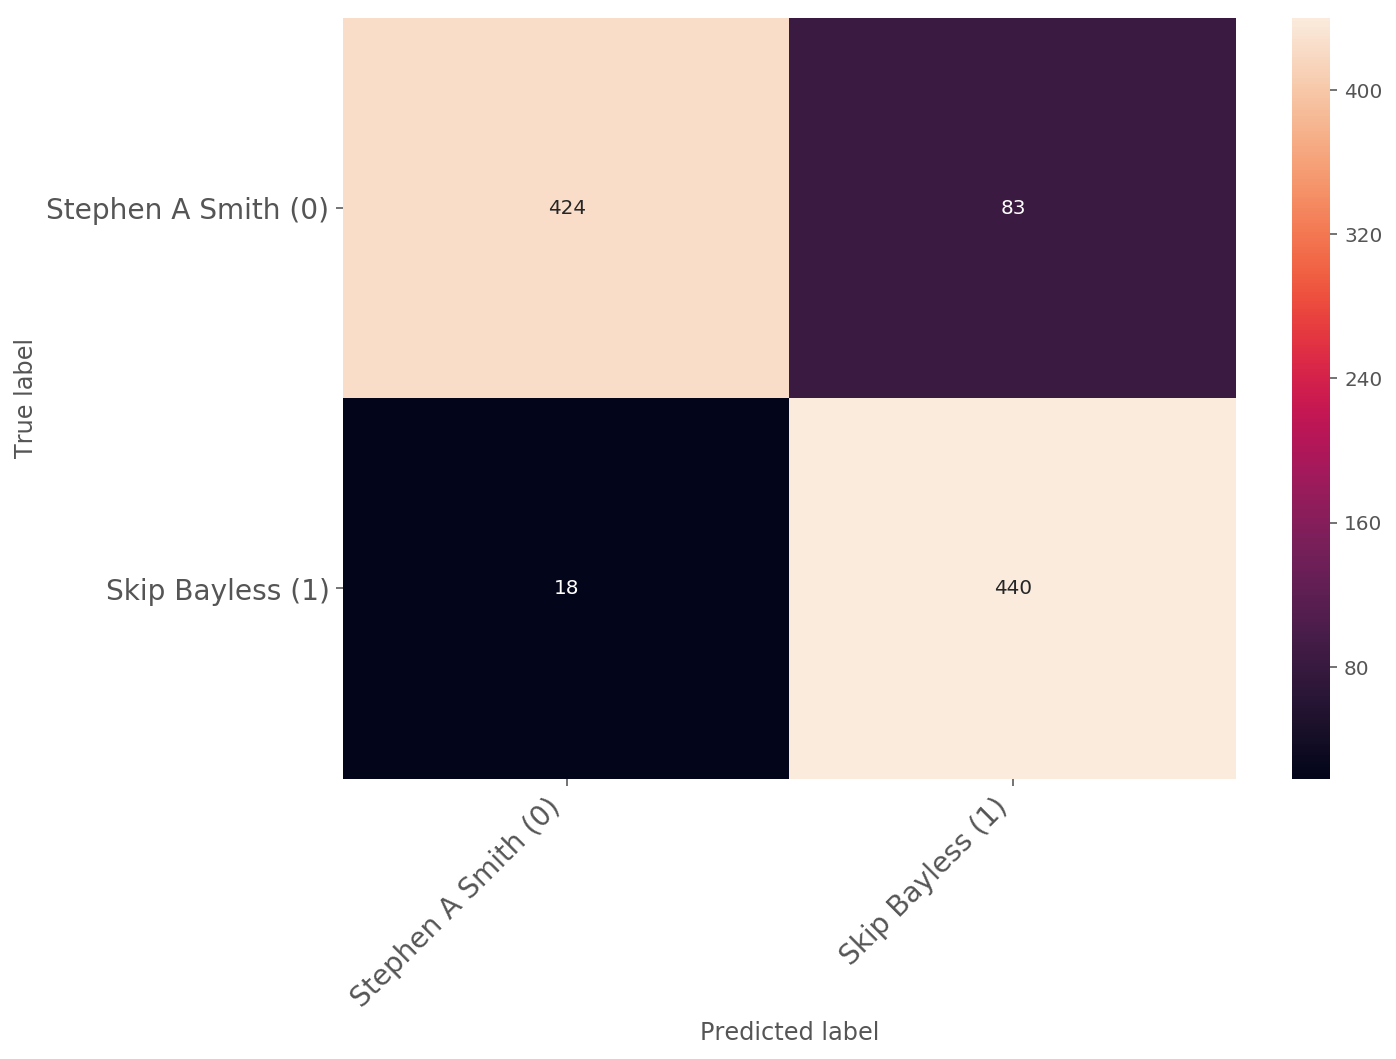

In [76]:
print_confusion_matrix(confusion_matrix(y_test, test_preds_mnb), class_names = ['Stephen A Smith (0)', 'Skip Bayless (1)'])

Lastly, we can calculate the accuracy, precision, and recall from this confusion matrix.

In [107]:
print("In the above confusion matrix, our Accuracy would be the sum of the values when predicted and \
actual labels correspond to each other or %s." %(round((424+440)/965, 3)))

print("\nThe recall would be the total number of retrieved and relevant instances out of the total relevant instances \
or %s."%(round(440/(440+18),3)))

print("\nThe precision would be the total number of retrieved and relevant instances out of the total amount of retrieved instances \
or %s."%(round(440/(440+83),3)))


In the above confusion matrix, our Accuracy would be the sum of the values when predicted and actual labels correspond to each other or 0.895.

The recall would be the total number of retrieved and relevant instances out of the total relevant instances or 0.961.

The precision would be the total number of retrieved and relevant instances out of the total amount of retrieved instances or 0.841.


### References 

https://radimrehurek.com/gensim/tut1.html